## **캐글필사: House Prices (Advanced)**

https://www.kaggle.com/code/subinium/subinium-tutorial-house-prices-advanced

주택 가격 예측하기 - Stacking 사용

- 스태킹과 앙상블에서 class 를 이용해보기
- 교차검증 함수 만들어 사용하기
- 전처리, 피처 엔지니어링 과정

### 1. 라이브러리, 데이터 확인

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler
from scipy import stats
from scipy.stats import norm, skew
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

# sns Theme
sns.set_style('darkgrid')

# 소수점 표현 제한
pd.set_option('display.float_format',lambda x:'{:.3f}'.format(x))

# 디렉토리 내, 사용가능 파일 체크
from subprocess import check_output
print(check_output(["ls","/content/drive/MyDrive/ESAA/과제/house data"]).decode("utf8"))

house_data_description.txt
house_sample_submission.csv
house_test.csv
house_train.csv



In [2]:
# 데이터 읽기
train_df = pd.read_csv('/content/drive/MyDrive/ESAA/과제/house data/house_train.csv')
test_df = pd.read_csv('/content/drive/MyDrive/ESAA/과제/house data/house_test.csv')

In [3]:
# 데이터 체크
print(train_df.shape, test_df.shape)
train_df.head()

(1460, 81) (1459, 80)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.000,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.000,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.000,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.000,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.000,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
# Save the 'ID' column
train_ID = train_df['Id']
test_ID = test_df['Id']

# drop thr 'Id' column since it's unnecessary for the prediction process
train_df.drop('Id',axis=1, inplace=True)
test_df.drop('Id',axis=1, inplace=True)

### 2. Data Processing  데이터 전처리

- 이상치의 처리

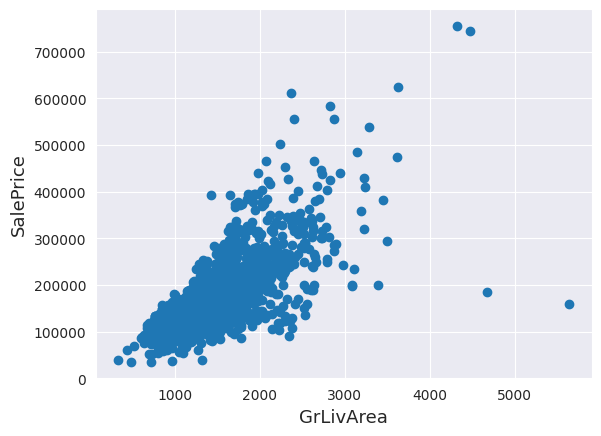

In [5]:
fig, ax = plt.subplots()

ax.scatter(x=train_df['GrLivArea'], y=train_df['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()

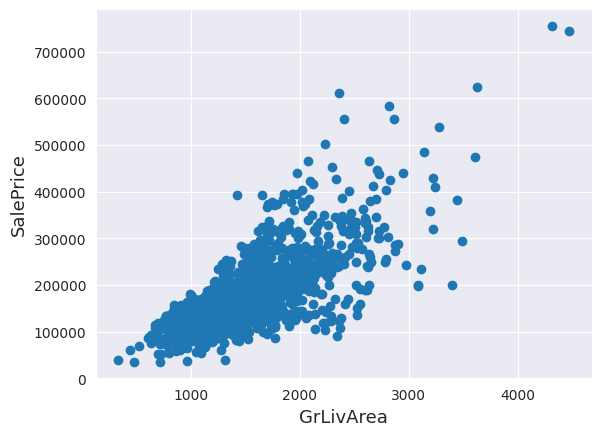

In [6]:
# 이상치 2개의 데이터 확인
# 이상치 삭제
train_df = train_df.drop(train_df[(train_df['GrLivArea']>4000) & (train_df['SalePrice']<300000)].index)

# 그래프 다시 확인
fig, ax = plt.subplots()
ax.scatter(x=train_df['GrLivArea'], y=train_df['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()

- Q-Q plot: 간단히 두 데이터 집단 간의 분포를 체크
- 타겟 변수 SalePrice의 분포 확인 > 왜곡되어 있음

180932.91906721535 79467.78892987774


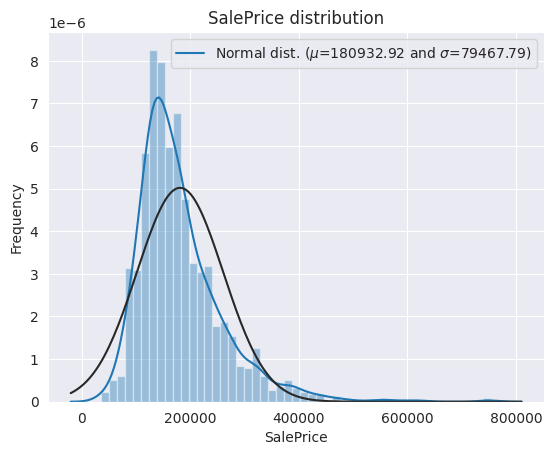

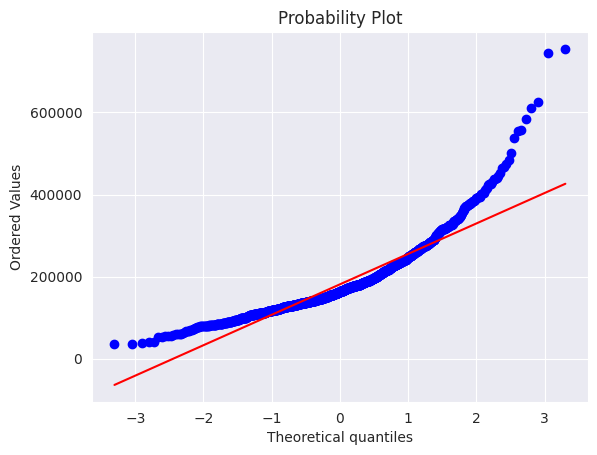

In [7]:
sns.distplot(train_df['SalePrice'], fit=norm)

# Get the fitted parameters used by the function - norm.fit
(mu, sigma) = norm.fit(train_df['SalePrice'])
print(mu, sigma)

# 분포를 그래프에 그리기
plt.legend(['Normal dist. ($\mu$={:.2f} and $\sigma$={:.2f})'.format(mu, sigma)], loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

# QQ plot을 그려보자
fig = plt.figure()
res = stats.probplot(train_df['SalePrice'], plot=plt)
plt.show()

- 로그 변환: 선형 회귀를 위한 데이터의 정규화

12.024015155682552 0.3995757283645756


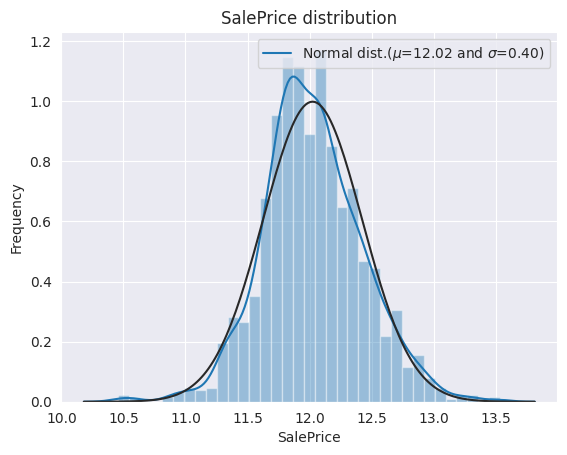

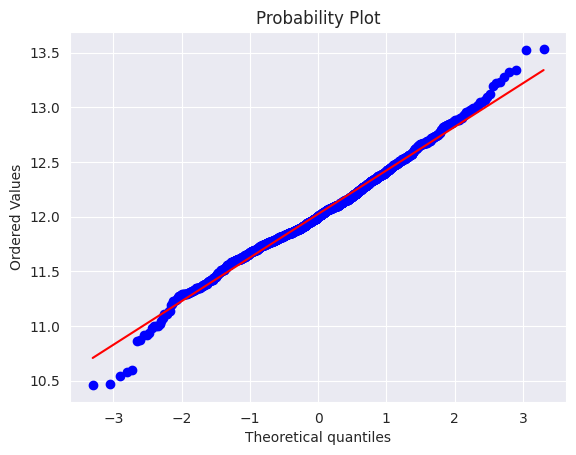

In [8]:
train_df['SalePrice'] = np.log1p(train_df['SalePrice'])

# 위에서와 같은 코드로 분포 확인
sns.distplot(train_df['SalePrice'], fit=norm)
(mu, sigma) = norm.fit(train_df['SalePrice'])
print(mu, sigma)
plt.legend(['Normal dist.($\mu$={:.2f} and $\sigma$={:.2f})'.format(mu,sigma)], loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

fig = plt.figure()
res = stats.probplot(train_df['SalePrice'], plot=plt)
plt.show()

### 3. Feature Engineering 피처 엔지니어링

In [9]:
# 데이터 묶어서 사용
ntrain = train_df.shape[0]
ntest = test_df.shape[0]

y_train = train_df.SalePrice.values

all_data = pd.concat((train_df, test_df)).reset_index(drop=True)
all_data.drop(['SalePrice'], axis=1, inplace=True)
print("all_data size is: {}".format(all_data.shape))

all_data size is: (2917, 79)


- NaN값 비율 확인

In [10]:
# Na값 확인
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na==0].index).sort_values(ascending=False)[:30]

missing_data = pd.DataFrame({"Missing Ratio": all_data_na})
missing_data.head(20)

,Missing Ratio
PoolQC,99.691
MiscFeature,96.400
Alley,93.212
Fence,80.425
MasVnrType,60.542
FireplaceQu,48.680
LotFrontage,16.661
GarageFinish,5.451
GarageQual,5.451
GarageCond,5.451


Text(0.5, 1.0, 'Percent missing data by feature')

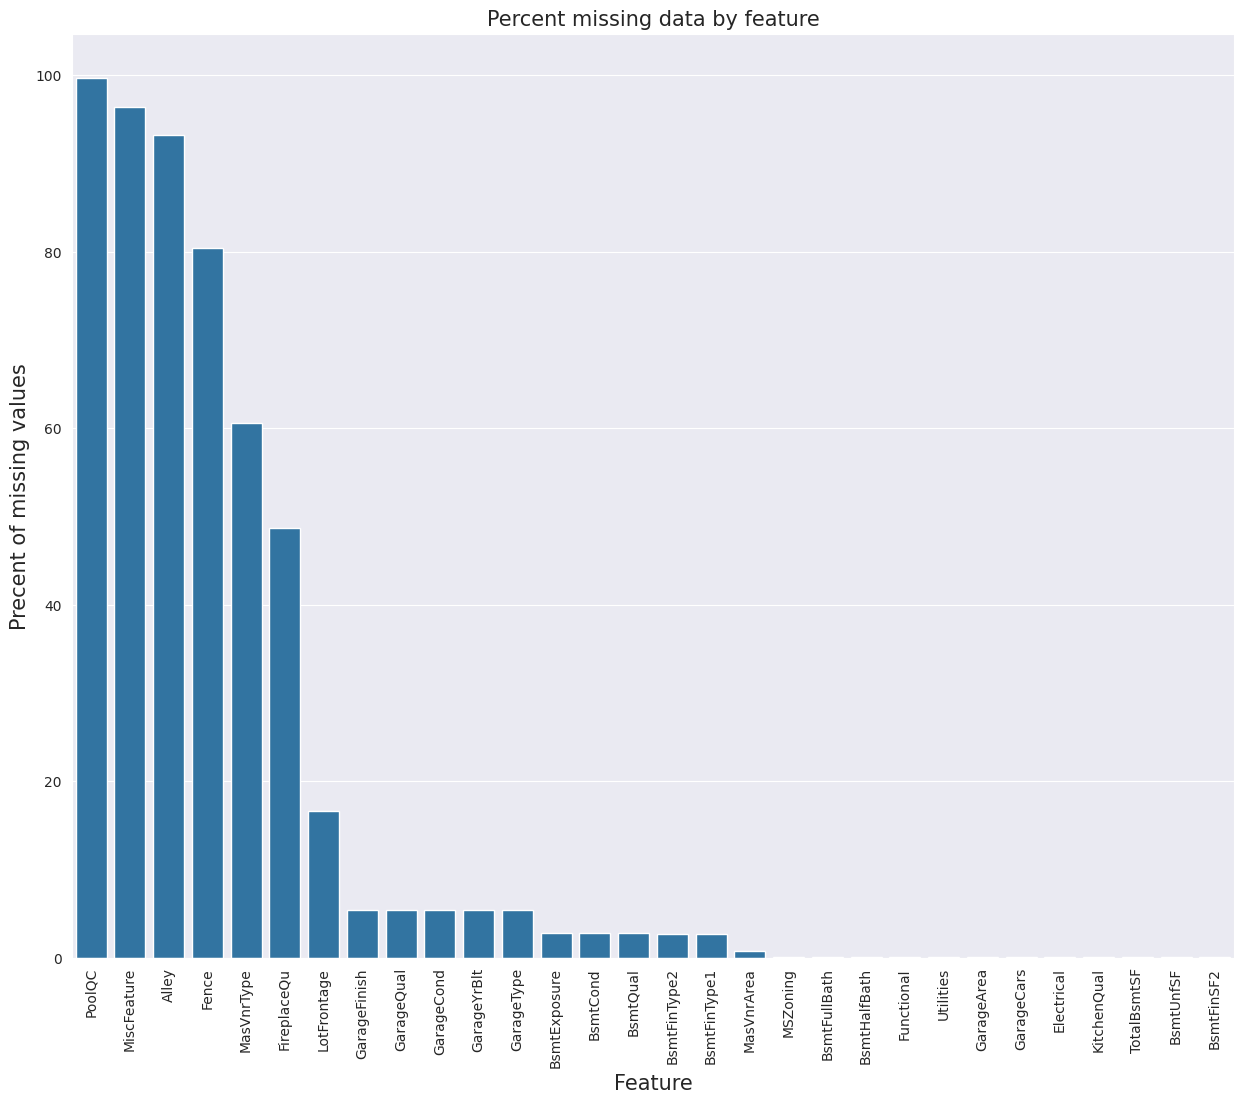

In [11]:
# 위의 비율 표를 시각화
f, ax = plt.subplots(figsize=(15,12))
plt.xticks(rotation =90)
sns.barplot(x=all_data_na.index, y=all_data_na)
plt.xlabel('Feature', fontsize=15)
plt.ylabel('Precent of missing values', fontsize=15)
plt.title('Percent missing data by feature', fontsize=15)

- 데이터 상관관계 시각화: 히트맵
   - 다른 요소와 SalePrice와의 관계 초점

<Axes: >

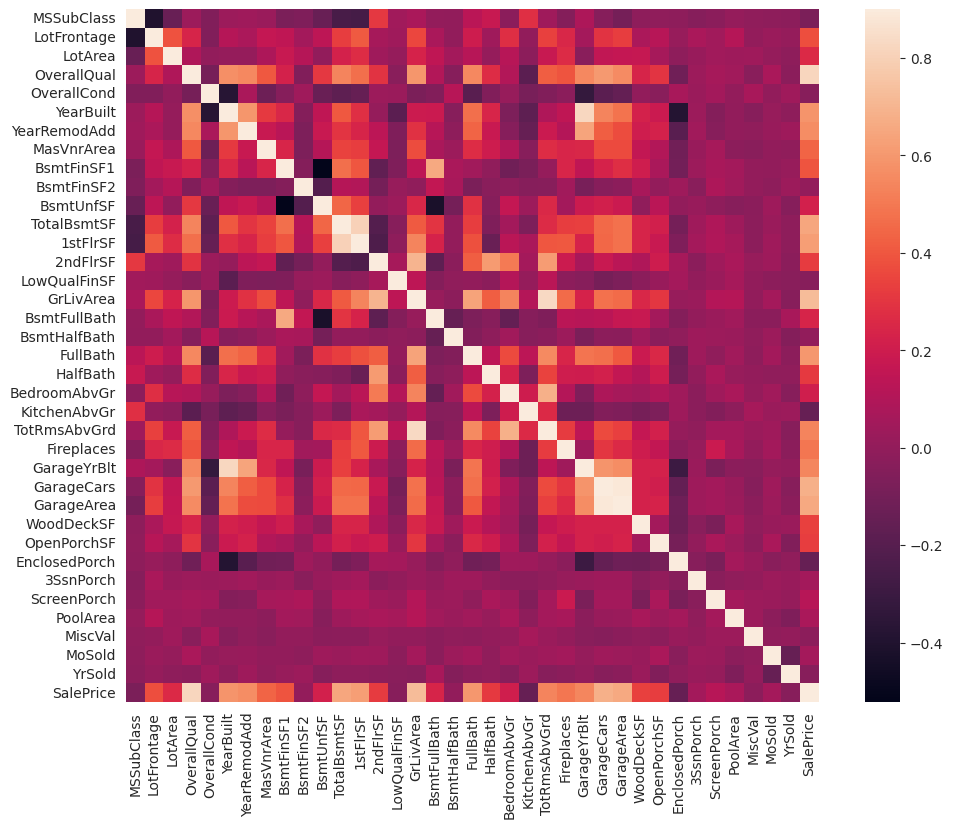

In [12]:
corrmat = train_df.select_dtypes(include=np.number).corr()
plt.subplots(figsize=(12,9))
sns.heatmap(corrmat, vmax=0.9, square=True)

- NaN 결측값 채우기
  - PoolQC: NA는 No Pool을 의미하므로 99%값으로 채움
  - MiscFeature, Alley, Fence, FirelpaceQu: no feature이므로 "None"
  - LotFrontage: 거리와 집의 거리. 중앙값으로 채움
  - GarageType, GarageFinish, GarageQual and GarageCond: "None"
  - GarageYrBlt, GarageArea, GarageCars: 0으로 채움
  - BsmtFinSF1, BsmtFinSF2, BsmtUnfSF,TotalBsmtSF, BsmtFullBath, BsmtHalfBath, MasVnrArea: 0으로 채움
  - BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1, BsmtFinType2, MasVnrType: 'None'으로 채움
  - MSZoning: RL이 최빈값으로 빈 부분은 최빈값mode로 채움
  - Utilities: 두 개의 값으로 이루어짐. 예측에 필요없으므로 drop
  - Functional: "Typ"으로 채움. 설명 참고함
  - Electrical, KitchenQual, Exterior1st and Exterior2nd, SaleType: 최빈값으로 채움
  

In [13]:
all_data["PoolQC"] = all_data["PoolQC"].fillna("None")

In [14]:
all_data["MiscFeature"] = all_data["MiscFeature"].fillna("None")
all_data["Alley"] = all_data["Alley"].fillna("None")
all_data["Fence"] = all_data["Fence"].fillna("None")
all_data["FireplaceQu"] = all_data["FireplaceQu"].fillna("None")

In [15]:
all_data["LotFrontage"] = all_data.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.median()))

In [16]:
for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'):
  all_data[col] = all_data[col].fillna('None')

In [17]:
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
  all_data[col] = all_data[col].fillna(0)

In [18]:
for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
  all_data[col] = all_data[col].fillna(0)

In [19]:
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
  all_data[col] = all_data[col].fillna('None')

In [20]:
all_data["MasVnrType"] = all_data["MasVnrType"].fillna("None")
all_data["MasVnrArea"] = all_data["MasVnrArea"].fillna(0)

In [21]:
all_data['MSZoning'] = all_data['MSZoning'].fillna(all_data['MSZoning'].mode()[0])

In [22]:
all_data = all_data.drop(['Utilities'], axis=1)

In [23]:
all_data["Functional"] = all_data["Functional"].fillna("Typ")

In [24]:
all_data['Electrical'] = all_data['Electrical'].fillna(all_data['Electrical'].mode()[0])

In [25]:
all_data['KitchenQual'] = all_data['KitchenQual'].fillna(all_data['KitchenQual'].mode()[0])

In [26]:
all_data['Exterior1st'] = all_data['Exterior1st'].fillna(all_data['Exterior1st'].mode()[0])
all_data['Exterior2nd'] = all_data['Exterior2nd'].fillna(all_data['Exterior2nd'].mode()[0])

In [27]:
all_data['SaleType'] = all_data['SaleType'].fillna(all_data['SaleType'].mode()[0])

In [28]:
all_data['MSSubClass'] = all_data['MSSubClass'].fillna("None")

In [29]:
# 남은 NaN값이 있는지 확인
all_data_na = (all_data.isnull().sum() / len(all_data))*100
all_data_na = all_data_na.drop(all_data_na[all_data_na==0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'Missing Ratio': all_data_na})
missing_data.head()

,Missing Ratio


- 범주형 피처들 변환
  - 레이블 인코딩

In [30]:
# MSSubClass = The building class
all_data['MSSubClass'] = all_data['MSSubClass'].apply(str)

# Changing OverallCond into a categorical variable
all_data['OverallCond']=all_data['OverallCond'].apply(str)

# Year and Month sold are transformed into categorical features
all_data['YrSold']=all_data['YrSold'].astype(str)
all_data['MoSold']=all_data['MoSold'].astype(str)

In [31]:
# 레이블 인코딩
from sklearn.preprocessing import LabelEncoder
cols = ('FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond',
        'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1',
        'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope',
        'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass', 'OverallCond',
        'YrSold', 'MoSold')

for c in cols:
  lbl=LabelEncoder()
  lbl.fit(list(all_data[c].values))
  all_data[c] = lbl.transform(list(all_data[c].values))

print('Shape all_data: {}'.format(all_data.shape))

Shape all_data: (2917, 78)


- 피처 추가: 집의 가용 평수 피처 생성(basement+1층+2층)

In [32]:
all_data['TotalSF'] = all_data['TotalBsmtSF'] + all_data['1stFlrSF']+all_data['2ndFlrSF']

In [33]:
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

# 수치형 데이터에서 skewness 체크
skewed_feats = all_data[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)

print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' : skewed_feats})
skewness.head(10)


Skew in numerical features: 



,Skew
MiscVal,21.940
PoolArea,17.689
LotArea,13.109
LowQualFinSF,12.085
3SsnPorch,11.372
LandSlope,4.973
KitchenAbvGr,4.301
BsmtFinSF2,4.145
EnclosedPorch,4.002
ScreenPorch,3.945


- Box Cox Transformation: 정규분포가 아닌 데이터를 정규 분포 형태로 변환

In [34]:
skewness = skewness[abs(skewness) > 0.75]
print('There are {} skewed numerical features to Box Cox transform'.format(skewness.shape[0]))

from scipy.special import boxcox1p
skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
  all_data[feat] = boxcox1p(all_data[feat], lam)

There are 59 skewed numerical features to Box Cox transform


- 범주형 데이터를 get_dummies로 변환, 데이터 세트 나누기

In [35]:
all_data = pd.get_dummies(all_data)
print(all_data.shape)

train_df = all_data[:ntrain]
test_df = all_data[ntrain:]

(2917, 220)


### 4. Modeling 모델링

- 모델 라이브러리 import

In [36]:
from sklearn.linear_model import ElasticNet, Lasso, BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb

- K-fold 정의

In [43]:
# Validation function
n_folds = 5
def rmsle_cv(model):
  kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(train_df.values)
  rmse = np.sqrt(-cross_val_score(model, train_df.values, y_train, scoring='neg_mean_squared_error', cv=kf))
  return (rmse)

- 베이스 모델:
  - LASSO 회귀: 이상치에 민감하므로 pipeline에 RobustScaler() 추가해 규제함
  - Elastic Net 회귀: 똑같이 규제함
  - Kernel Ridge 회귀
  - Gradient Boosting 회귀: hurber 손실 함수로 이상치 관리. 이상치에 민감하지 않음
  - XGBoost : 베이지안 최적화로 하이퍼 파라미터 설정
  - LGBM

In [38]:
lasso = make_pipeline(RobustScaler(), Lasso(alpha=0.0005, random_state=1))
ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3))
KRR = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)

In [39]:
GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10,
                                   loss='huber', random_state=5)

In [40]:
model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468,
                             learning_rate=0.05, max_depth=3,
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state=7, nthread= -1)

In [50]:
model_lgb = lgb.LGBMRegressor(objective='regression', num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin=55, bagging_fraction=0.8,
                              bagging_freq=5, feature_fraction=0.2319,
                              features_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf = 6, min_sum_hessian_in_leaf=11, verbose=-1)

- 베이스 모델 스코어: 교차검증으로 score 구하기

In [44]:
score = rmsle_cv(lasso)
print("\nLasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


Lasso score: 0.1115 (0.0074)



In [45]:
score = rmsle_cv(ENet)
print("\nElasticNet score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


ElasticNet score: 0.1116 (0.0074)



In [46]:
score = rmsle_cv(KRR)
print("\nKernel Ridge score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


Kernel Ridge score: 0.1153 (0.0075)



In [47]:
score = rmsle_cv(GBoost)
print("\nGradient Boosting score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


Gradient Boosting score: 0.1167 (0.0083)



In [48]:
score = rmsle_cv(model_xgb)
print("\nXgboost score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


Xgboost score: 0.1167 (0.0068)



In [51]:
score = rmsle_cv(model_lgb)
print("\nLGBM score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


LGBM score: 0.1160 (0.0064)



- 스태킹 모델
  - 모델들의 성능을 평균해 사용: ENet, GBoost, KRR, Lasso

In [54]:
# class로 생성하여 재사용
class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
  def __init__(self, models):
    self.models = models

  # define clones of the original models to fit data in
  def fit(self, X, y):
    self.models_ = [clone(x) for x in self.models]

    # Train cloned base models
    for model in self.models_:
      model.fit(X,y)

    return self

  # cloned models로 예측, 평균
  def predict(self, X):
    predictions = np.column_stack([
        model.predict(X) for model in self.models_
    ])
    return np.mean(predictions, axis=1)

In [55]:
# 평균 base models score
averaged_models = AveragingModels(models=(ENet, GBoost, KRR, lasso))
score = rmsle_cv(averaged_models)
print('Averaged base models score: {:.4f} ({:.4f})\n'.format(score.mean(), score.std()))

Averaged base models score: 0.1087 (0.0077)



- Less simple Stacking
  - 메타모델 추가, base model의 평균과 out or folds 예측을 이용해 메타모델 훈련

  - 1. 훈련데이터를 분리된 데이터셋으로 나눔
    2. train 데이터로 훈련
    3. holdout 데이터로 테스트
    4. 예측값 구하고 메타모델로 모델 학습

  - 5-폴드 예시: 훈련데이터를 5개로 나누고 5번 반복. 4개의 폴드로 훈련 후 1개의 예측값 5번을 내서 평균내고 이를 메타모델 피처로 사용한다

  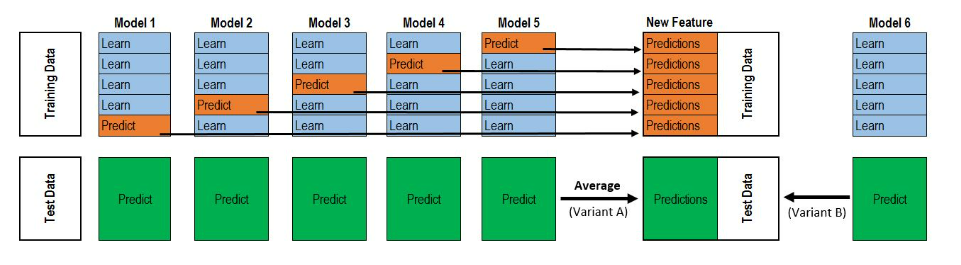

In [57]:
class StackingAveragedModels(BaseEstimator, RegressorMixin, TransformerMixin):
  def __init__(self, base_models, meta_model, n_folds=5):
    self.base_models = base_models
    self.meta_model = meta_model
    self.n_folds = n_folds

  # base_models_는 2차원 배열
  def fit(self, X, y):
    self.base_models_ = [list() for x in self.base_models]
    self.meta_model_ = clone(self.meta_model)
    kfold = KFold(n_splits=self.n_folds, shuffle=True, random_state=156)

    # Train cloned base models then create out-of-fold predictions
    # that are needed to train thr cloned meta-model
    out_of_fold_predictions = np.zeros((X.shape[0], len(self.base_models)))
    for i, model in enumerate(self.base_models):
      for train_index, holdout_index in kfold.split(X,y):
        instance = clone(model)
        self.base_models_[i].append(instance)
        instance.fit(X[train_index], y[train_index])
        y_pred = instance.predict(X[holdout_index])
        out_of_fold_predictions[holdout_index, i] = y_pred

    # Now train the cloned meta-model using the out of fold predictions as new feature
    self.meta_model_.fit(out_of_fold_predictions, y)
    return self

  def predict(self, X):
    meta_features = np.column_stack([
        np.column_stack([model.predict(X) for model in base_models]).mean(axis=1)
        for base_models in self.base_models_ ])
    return self.meta_model_.predict(meta_features)

- stacking averaged models score: 성능 비교

In [59]:
stacked_averaged_models = StackingAveragedModels(
    base_models = (ENet, GBoost, KRR),
    meta_model = (lasso)
)

score = rmsle_cv(stacked_averaged_models)
print('Stacking Averaged models score: {:.4f} ({:.4f})'.format(score.mean(), score.std()))

Stacking Averaged models score: 0.1081 (0.0073)


- Ensembling StackedRegressor, XGBoost, LGBM

In [60]:
# rmsle 함수
def rmsle(y, y_pred):
  return np.sqrt(mean_squared_error(y,y_pred))

-  - 최종 학습, 예측: 전체 (평균)학습 데이터에 대한 rmse 계산

In [61]:
# StackedRegressor
stacked_averaged_models.fit(train_df.values, y_train)
stacked_train_pred = stacked_averaged_models.predict(train_df.values)
stacked_pred = np.expm1(stacked_averaged_models.predict(test_df.values))
print(rmsle(y_train, stacked_train_pred))

0.07839506096665937


In [64]:
# XGBoost
model_xgb.fit(train_df, y_train)
xgb_train_pred = model_xgb.predict(train_df)
xgb_pred = np.expm1(model_xgb.predict(test_df))
print(rmsle(y_train, xgb_train_pred))

0.0866951518038854


In [66]:
# LGBM
model_lgb.fit(train_df, y_train)
lgb_train_pred = model_lgb.predict(train_df)
lgb_pred = np.expm1(model_lgb.predict(test_df.values))
print(rmsle(y_train, lgb_train_pred))

0.07255428955736014


In [67]:
''' RMSE on the entire Train data when averaging'''
print('RMSLE score on train data:')
print(rmsle(y_train,stacked_train_pred*0.70 +
               xgb_train_pred*0.15 + lgb_train_pred*0.15 ))

# 앙상블의 가중치는 교차검증 score에 따라 적용.
# Stacked Regressor의 CV mean score

RMSLE score on train data:
0.07669353914822369


In [69]:
ensemble = stacked_pred*0.7 + xgb_pred*0.15 + lgb_pred*0.15

- 제출

In [70]:
sub = pd.DataFrame()
sub['Id'] = test_ID
sub['SalePrice'] = ensemble
sub.to_csv('submission.csv', index=False)